# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn

df_transactions.describe() #we have 324 transactions.
df_transactions.nunique() #we have 100 customer names and 32 offers. We expect 32 columns & 100 rows after pivoting.
#df_offers.describe()

customer_name    100
offer_id          32
n                  1
dtype: int64

In [6]:
df = df_transactions.merge(df_offers, how='left', on='offer_id')[['customer_name', 'offer_id', 'n']]
#this gives us a dataframe with just our 3 columns of interest (name, offer, and n)

table = pd.pivot_table(df, index=['customer_name'], columns=['offer_id'])
#index is name, columns are each offer. NaN value = no response. Value of 1 = responded to offer.

table = table.fillna(0) #change all NaN values to 0

df_responses = table.reset_index() #makes customer_name into its own column.
df_responses.head()

customer_name    n                                          ...       \
offer_id                  1    2    3    4    5    6    7    8    9  ...   23   
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   

                                                       
offer_id   24   25   26   27   28   29   30   31   32  
0         0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
1         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
2         1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 33 columns]

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [7]:
# your turn

# Q: What values of 𝑆𝑆 do you believe represent better clusterings? Why?
# A: A smaller value of SS represents better clusterings, because that indicates the centroids are representing
#    each cluster better (i.e. it truly is within a cluster). But if each increase in K leads to smaller and smaller
#    gains in the SS, then we are at risk of overfitting our data (hence why we look for the "elbow").

# Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)
x_cols = table.n.reset_index(drop=True).to_numpy()
x_cols.sum() #we get sum of 324, which is the same number of transactions as df_transactions, as we expect.

324.0

In [8]:
# Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) 
# clustering method from scikit-learn to this matrix.

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42).fit(x_cols) #try out n=2 and check the results
kmeans.labels_ #we get results for 0 and 1, i.e. one of two clusters

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1])

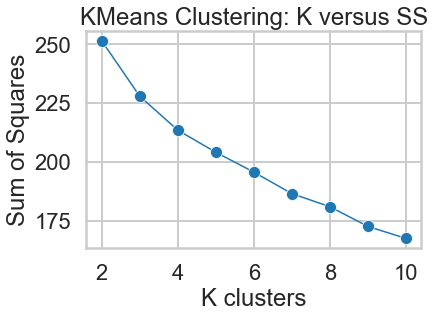

In [235]:
# Construct a plot showing  𝑆𝑆  for each  𝐾  and pick  𝐾  using this plot. For simplicity, test  2≤𝐾≤10 .

x_ss = []
y_ss = []

for n in range(2,11):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(x_cols)
    x_ss.append(n)
    y_ss.append(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.

_=plt.xlabel('K clusters')
_=plt.ylabel('Sum of Squares')
_=plt.title('KMeans Clustering: K versus SS')
_=sns.lineplot(x_ss,y_ss, marker='o', size=100, legend=False)

# The slope appears steepest between [2,3], and then becomes increasingly shallow as K increases. 
# We can identify K=3 as the "elbow".

[0, 1, 2]
[37, 16, 47]


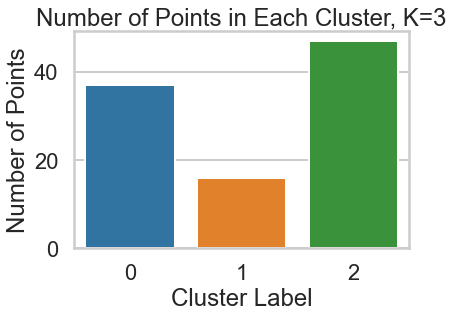

In [10]:
# Make a bar chart showing the number of points in each cluster for k-means under the best  𝐾 .

kmeans = KMeans(n_clusters=3, random_state=42).fit(x_cols) #from before, use K=3 as best K.
array = kmeans.labels_ #everything is sorted into 0, 1, or 2 (i.e. 3 clusters)

x_points = []
y_points = []

for i in range(3):
    x_points.append(i)
    y_points.append(np.count_nonzero(array == i))

_=plt.xlabel('Cluster Label')
_=plt.ylabel('Number of Points')
_=plt.title('Number of Points in Each Cluster, K=3')
_=sns.barplot(x_points, y_points)

print(x_points)
print(y_points)

[0, 1, 2, 3]
[23, 16, 36, 25]


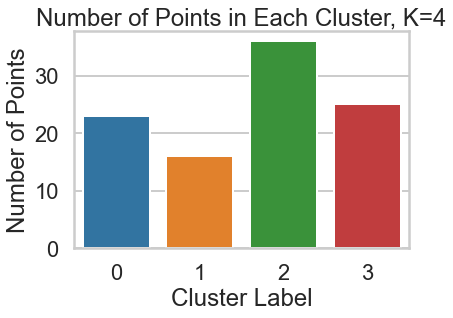

In [11]:
# Q: What challenges did you experience using the Elbow method to pick  𝐾 ?
# A: The challenge with the elbow method is that it's subjective. I originally plotted the K vs. SS as a lineplot, 
#    But because the change in slope is so light with each increasing K, it was difficult to interpret the lineplot 
#    and determine what the best K actually was. I switched to a scatterplot to more easily see where each (x,y)
#    value was. I determined that K=3 waste the best K, but someone else could just as easily have decided that
#    K=4 was the best K. Just to see how our barplot would've turned out differently, below is our barchart with K=4.

kmeans = KMeans(n_clusters=4, random_state=42).fit(x_cols)
array = kmeans.labels_

x_points = []
y_points = []

for i in range(4):
    x_points.append(i)
    y_points.append(np.count_nonzero(array == i))

_=plt.xlabel('Cluster Label')
_=plt.ylabel('Number of Points')
_=plt.title('Number of Points in Each Cluster, K=4')
_=sns.barplot(x_points, y_points)

print(x_points)
print(y_points)

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.1107183912025193
For n_clusters = 4 The average silhouette_score is : 0.12349204708263416
For n_clusters = 5 The average silhouette_score is : 0.11482891379977885
For n_clusters = 6 The average silhouette_score is : 0.11879508142787866
For n_clusters = 7 The average silhouette_score is : 0.10874624428071616
For n_clusters = 8 The average silhouette_score is : 0.14097216560635834
For n_clusters = 9 The average silhouette_score is : 0.14178613108021745
For n_clusters = 10 The average silhouette_score is : 0.12819851045484193


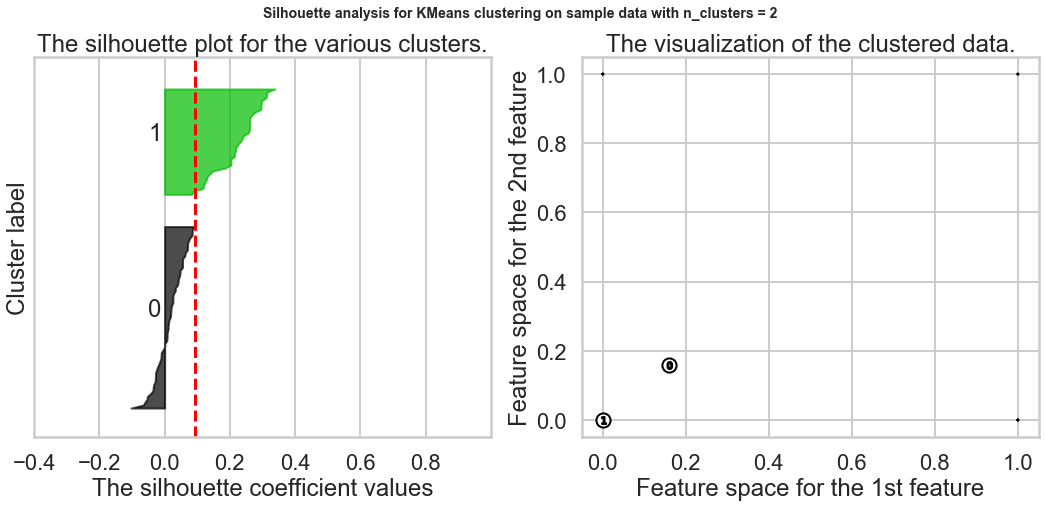

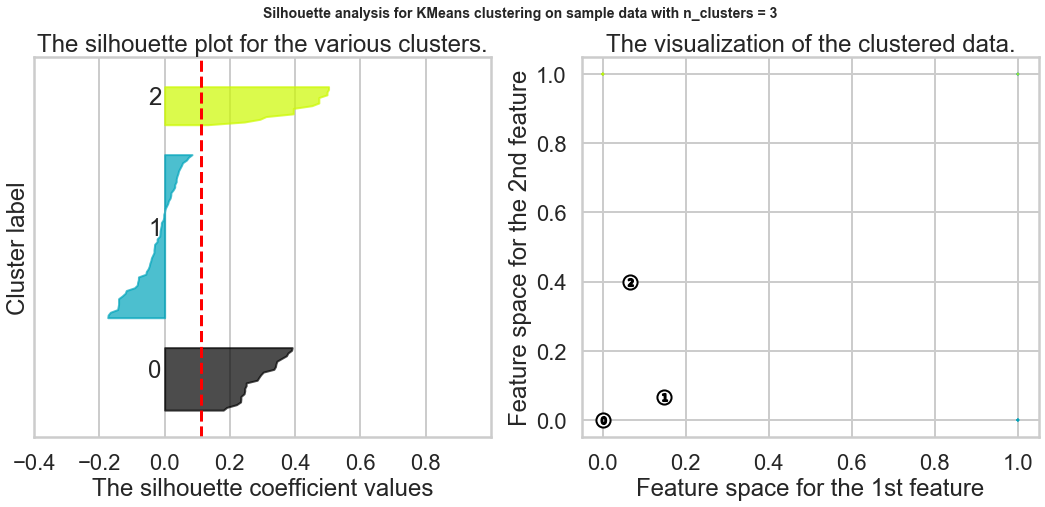

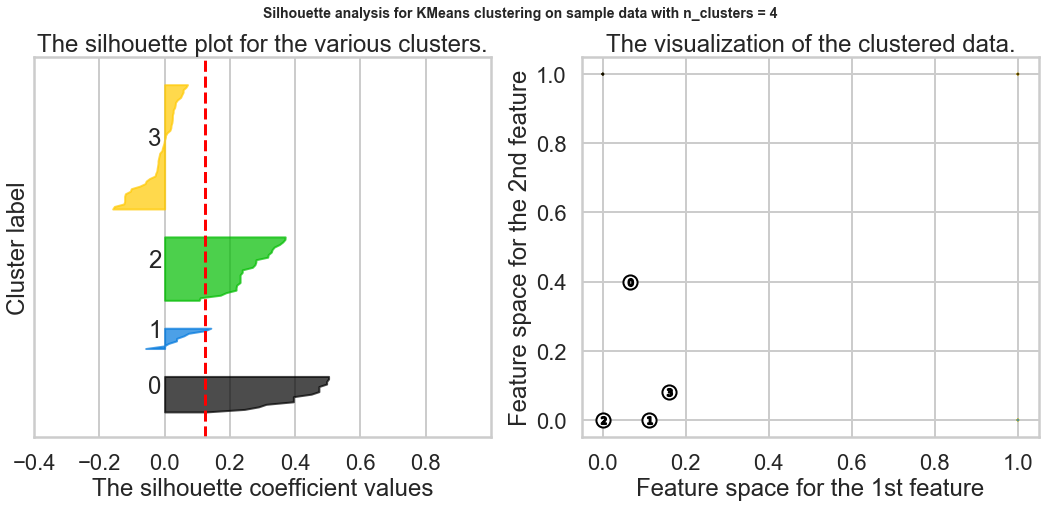

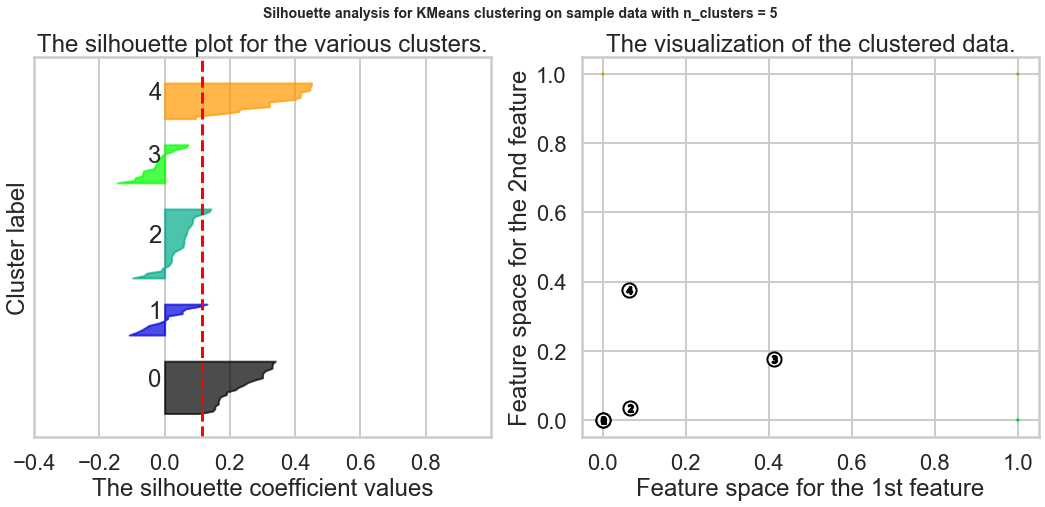

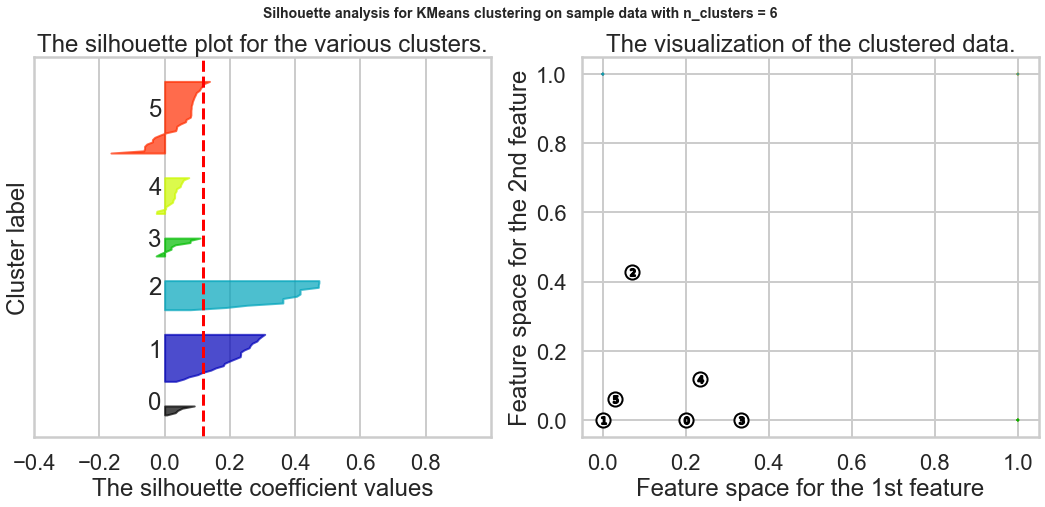

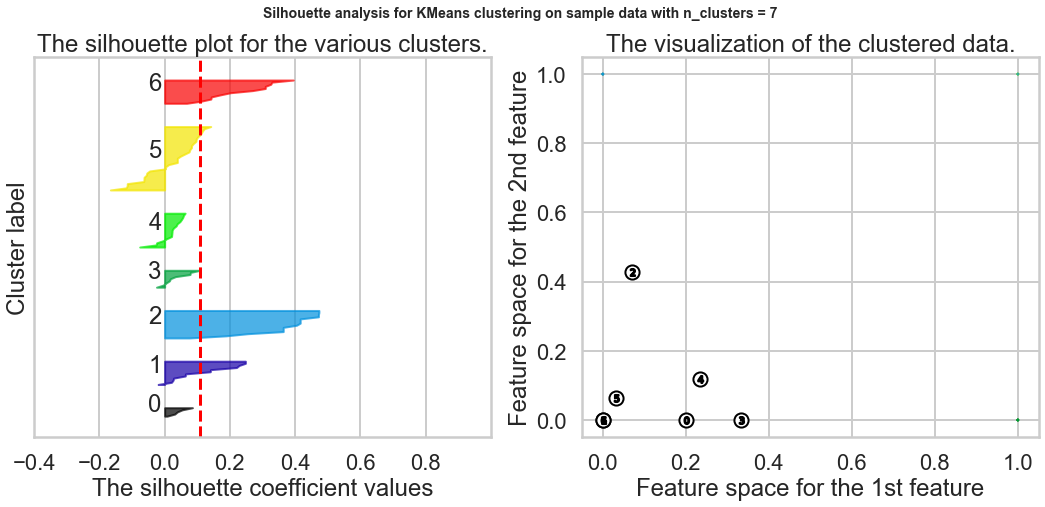

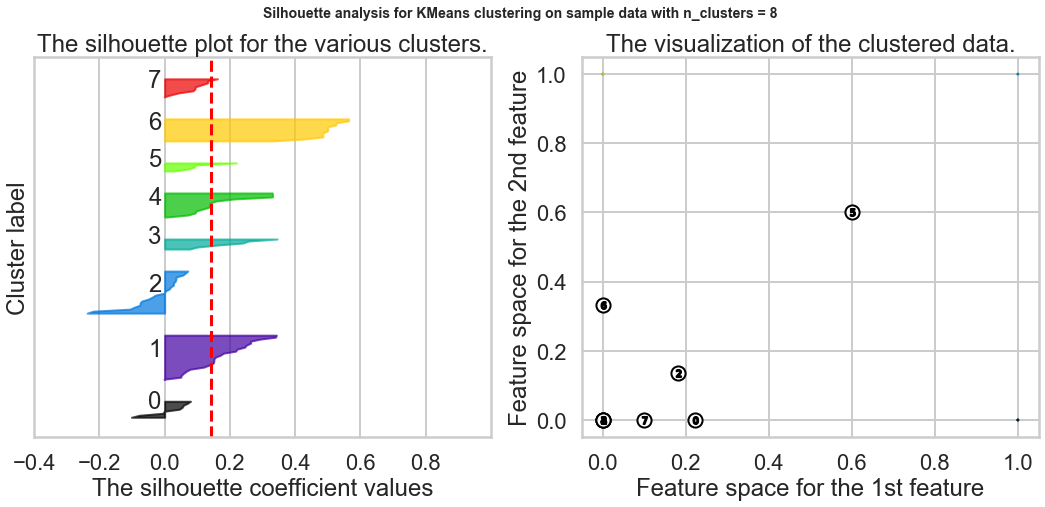

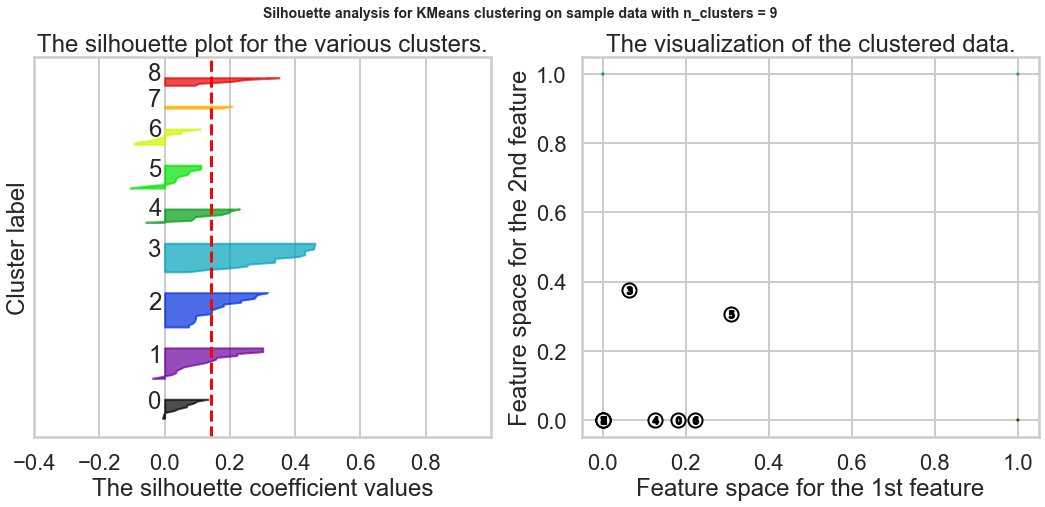

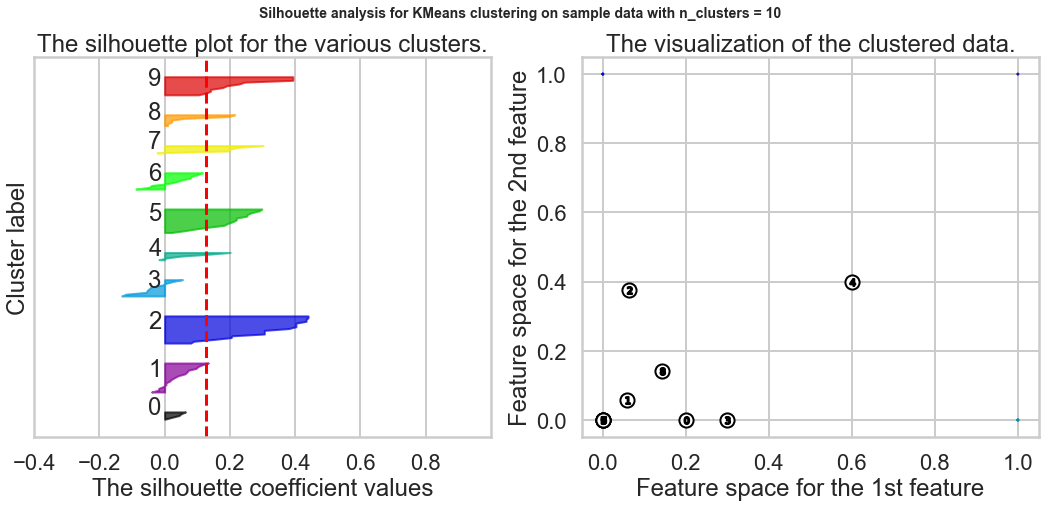

In [15]:
# Your turn.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

X = x_cols #Use the array from before 

range_n_clusters = np.arange(2,11) #Use the same range as before: 2≤𝐾≤10

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1. But we'll do -0.4 to 1. 
    ax1.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.4, 1, 0.2))

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()



Our results are the following:
 * For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
 * For n_clusters = 3 The average silhouette_score is : 0.1107183912025193
 * For n_clusters = 4 The average silhouette_score is : 0.12349204708263416
 * For n_clusters = 5 The average silhouette_score is : 0.11482891379977885
 * For n_clusters = 6 The average silhouette_score is : 0.11879508142787866
 * For n_clusters = 7 The average silhouette_score is : 0.10874624428071616
 * For n_clusters = 8 The average silhouette_score is : 0.14097216560635834
 * For n_clusters = 9 The average silhouette_score is : 0.14178613108021745
 * For n_clusters = 10 The average silhouette_score is : 0.12819851045484193
 
The K with the highest silhouette scores are K = 8 and K = 9, with K = 10 and K = 4 close behind. This is very different from what we had picked before (with K = 3 or 4 being the "elbow"). Unfortunately, everything is below 0.25, so there is no substantial structure found.

In [22]:
X = x_cols

cluster = []
score = []

range_n_clusters = np.arange(2,80) #Let's try again with a larger range, and find the max silhouette score.
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster.append(n_clusters)
    score.append(silhouette_avg)

max_score = max(score)
max_score_index = score.index(max_score)
max_score_cluster = cluster[max_score_index]
print("The max silhouette score is: ", max_score, " with n_clusters: ", max_score_cluster)

The max silhouette score is:  0.2197334246861903  with n_clusters:  68


When we try finding the silhouette score, this time with more than just 10 clusters (we go up to 80), we find that the best score is 0.2197334246861903 with K = 68. This information is not all that helpful as we only have 100 points, and the silhouette score is still below 0.25, so no substantial structure is found.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [115]:
#your turn

#Use scikit-learn's [`PCA`] function to reduce the dimensionality of your clustering data to 2 components

from sklearn.decomposition import PCA
X = x_cols
pca = PCA(n_components=2)
results = pca.fit_transform(X)

results_x = []
results_y = []

for i in range(100):
    results_x.append(results[i][0])
    results_y.append(results[i][1])

#Create a data frame with the following fields:
    #customer name
    #cluster id the customer belongs to
    #the two PCA components (label them `x` and `y`)

kmeans = KMeans(n_clusters=3, random_state=10).fit(x_cols) #We choose K=3 from our initial elbow method.
df_pca = df_responses[['customer_name']].melt()[['value']] #We use melt() to unpivot our earlier df.
df_pca.columns = ['customer_name'] #rename the column
df_pca['cluster_id'] = kmeans.labels_
df_pca['x'] = results_x
df_pca['y'] = results_y
df_pca.head()

,customer_name,cluster_id,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


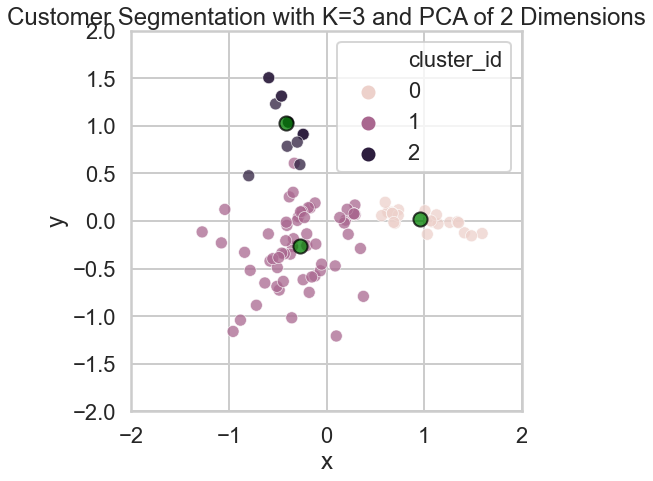

In [140]:
#Plot a scatterplot of the `x` vs `y` columns
#Color-code points differently based on cluster ID

fig, ax = plt.subplots(figsize=(7,7))
_=plt.title('Customer Segmentation with K=3 and PCA of 2 Dimensions')
_=plt.xlim([-2, 2])
_=plt.ylim([-2, 2])

_=sns.scatterplot(data=df_pca, x='x',y='y', hue='cluster_id', alpha = 0.75)

# Draw circles at cluster centers
center_x=[]
center_y=[]
for i in df_pca.cluster_id.unique():
    x = np.mean(df_pca.x[df_pca.cluster_id==i])
    y = np.mean(df_pca.y[df_pca.cluster_id==i])
    center_x.append(x)
    center_y.append(y)
_=plt.scatter(center_x, center_y, marker='o', c="green", alpha=0.75, s=200, edgecolor='k')


__#How do the clusters look?__

Clusters 0 and 2 look fairly well-defined. They appear as tails of the scatterplot: 
* Cluster 0 consistently has a y-component value close to zero, while having a positive value of the x-component (perhaps these are people who consistently take up one specific type of offer (like purchasing expensive wine) while ignoring all other offers for other wine types). 
* Cluster 2 consistently has a x-component value around -0.4, while having a postive y-component value that's >= 0.5 (perhaps these are people who are the opposite of the Cluster 0 customers (for example, perhaps they like to avoid the expensive wine)).

Cluster 1 is more spread out and poorly defined. This large, varied cluster is probably why the silhouette score was so poor, and something as high as K=9 clusters performed well (it was over-fitting the data). This final cluster has a center around (-0.25, -0.25), indicating that these are people who have neither high values in components x or y. These are customers who select offers that are for neither of the reasons which customers Cluster 0 and Cluster 2 purchase for. 


__#Based on what you see, what seems to be the best value for  𝐾 ? Moreover, which method of choosing  𝐾  seems to have produced the optimal result visually?__

The best value for K is 3: one for each of the 2 tails, and one for the remaining nebulous cluster of points. From visual inspection, the elbow method appears to have produced the optimal result. Ironically, this is the method that I criticized for being the most subjective, but when plotting the 2-dimensional PCA, it appears that K=3 was the best choice, and that result had come from the elbow sum-of-squares method.

In [175]:
#Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. 
#Tell a story about the clusters in context of the original data. 
#For example, do the clusters correspond to wine variants or something else interesting?

# Since clusters 0 and 2 appear most interesting, let's look at those two clusters
# and see what offers those customers took. We can plot the PCA again with different offer details as hues/colors.

# First we make a new df with the customer name, offer_id, and offer details.
df_pca_offer = df_transactions.merge(df_pca, how='left', on='customer_name').merge(df_offers, how='left', on='offer_id')
df_pca_offer.head()

,customer_name,offer_id,n,cluster_id,x,y,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,2,-0.300227,0.829765,January,Pinot Noir,72,17,France,False
1,Smith,24,1,2,-0.300227,0.829765,September,Pinot Noir,6,34,Italy,False
2,Johnson,17,1,2,-0.461726,1.313485,July,Pinot Noir,12,47,Germany,False
3,Johnson,24,1,2,-0.461726,1.313485,September,Pinot Noir,6,34,Italy,False
4,Johnson,26,1,2,-0.461726,1.313485,October,Pinot Noir,144,83,Australia,False


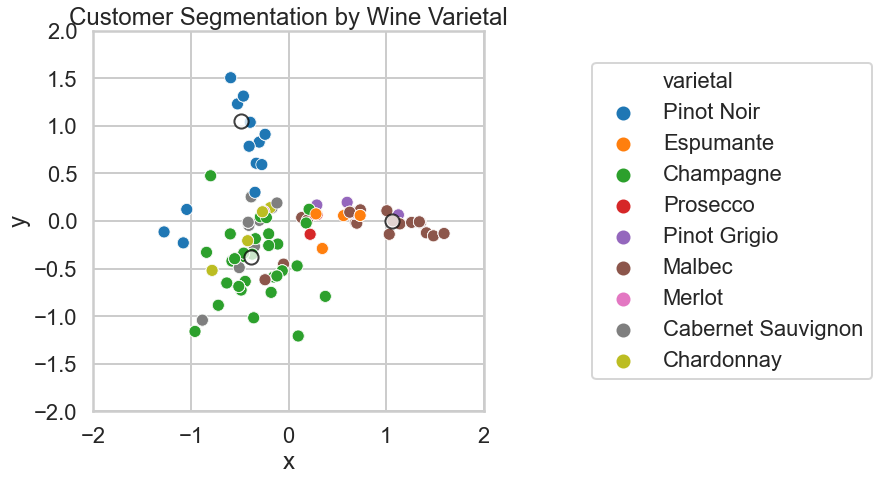

In [200]:
# Now let's plot the 2-component PCA, while setting "hue" as the different variables.

#By Wine Varietal

fig, ax = plt.subplots(figsize=(7,7))
_=plt.title('Customer Segmentation by Wine Varietal')
_=plt.xlim([-2, 2])
_=plt.ylim([-2, 2])

_=sns.scatterplot(data=df_pca_offer, x='x',y='y', hue='varietal', alpha = 1, legend='full')
_=ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

center_x=[]
center_y=[]
for i in df_pca.cluster_id.unique():
    x = np.mean(df_pca_offer.x[df_pca_offer.cluster_id==i])
    y = np.mean(df_pca_offer.y[df_pca_offer.cluster_id==i])
    center_x.append(x)
    center_y.append(y)
_=plt.scatter(center_x, center_y, marker='o', c="white", alpha=0.75, s=200, edgecolor='k')

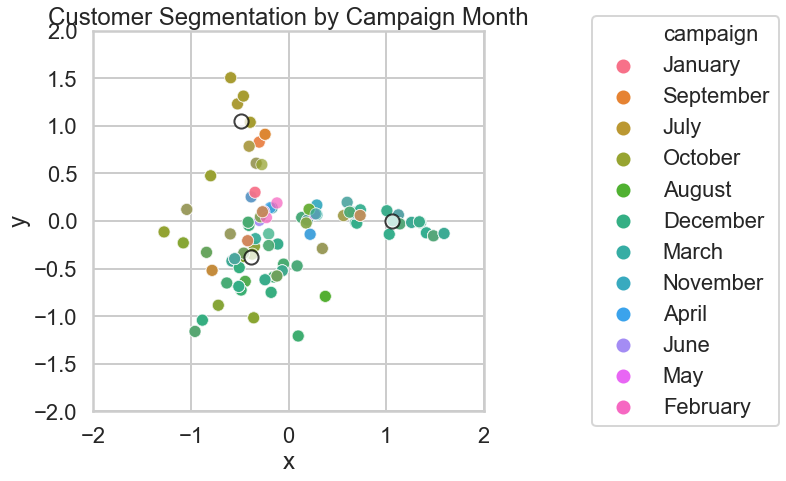

In [203]:
#By Campaign Month

fig, ax = plt.subplots(figsize=(7,7))
_=plt.title('Customer Segmentation by Campaign Month')
_=plt.xlim([-2, 2])
_=plt.ylim([-2, 2])

_=sns.scatterplot(data=df_pca_offer, x='x',y='y', hue='campaign', alpha = 0.75, legend='full')
_=ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

center_x=[]
center_y=[]
for i in df_pca.cluster_id.unique():
    x = np.mean(df_pca_offer.x[df_pca_offer.cluster_id==i])
    y = np.mean(df_pca_offer.y[df_pca_offer.cluster_id==i])
    center_x.append(x)
    center_y.append(y)
_=plt.scatter(center_x, center_y, marker='o', c="white", alpha=0.75, s=200, edgecolor='k')

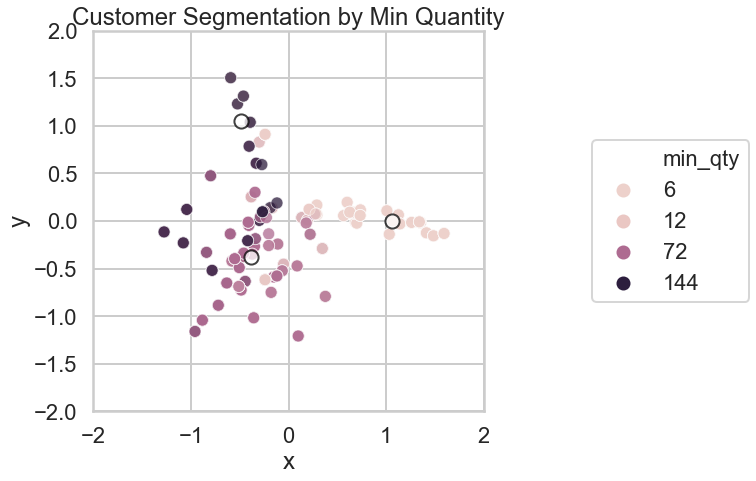

In [205]:
#By min_qty

fig, ax = plt.subplots(figsize=(7,7))
_=plt.title('Customer Segmentation by Min Quantity')
_=plt.xlim([-2, 2])
_=plt.ylim([-2, 2])

_=sns.scatterplot(data=df_pca_offer, x='x',y='y', hue='min_qty', alpha = 0.75, legend='full')
_=ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

center_x=[]
center_y=[]
for i in df_pca.cluster_id.unique():
    x = np.mean(df_pca_offer.x[df_pca_offer.cluster_id==i])
    y = np.mean(df_pca_offer.y[df_pca_offer.cluster_id==i])
    center_x.append(x)
    center_y.append(y)
_=plt.scatter(center_x, center_y, marker='o', c="white", alpha=0.75, s=200, edgecolor='k')

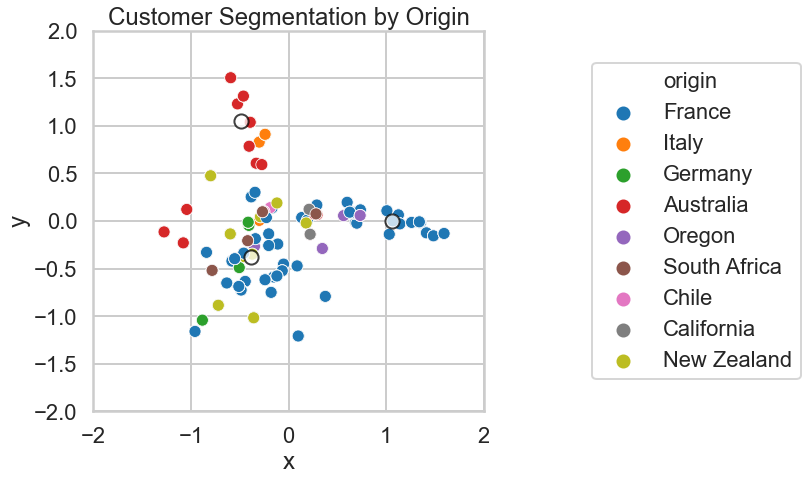

In [196]:
# By origin

fig, ax = plt.subplots(figsize=(7,7))
_=plt.title('Customer Segmentation by Origin')
_=plt.xlim([-2, 2])
_=plt.ylim([-2, 2])

_=sns.scatterplot(data=df_pca_offer, x='x',y='y', hue='origin', alpha = 1, legend='full')
_=ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

center_x=[]
center_y=[]
for i in df_pca.cluster_id.unique():
    x = np.mean(df_pca_offer.x[df_pca_offer.cluster_id==i])
    y = np.mean(df_pca_offer.y[df_pca_offer.cluster_id==i])
    center_x.append(x)
    center_y.append(y)
_=plt.scatter(center_x, center_y, marker='o', c="white", alpha=0.75, s=200, edgecolor='k')

__Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?__

From the graphs above, we notice the following patterns:
* __Cluster 0__ (right tail)
  * Dominant Varietal: Malbec, followed by Pinot Grigio and Espumante
  * Campaign: primarily winter months (December)
  * Min Quantity: qty 6 or 12
  * Origin: France
* __Cluster 1__ (nebulous center)
  * Dominant Varietal: Champagne, followed by Chardonnay and Cabernet Sauvignon
  * Campaign: no visible pattern (all the months)
  * Min Quantity: qty 72, followed by qty 144, 12, and 6
  * Origin: no visible pattern (all the countries)
* __Cluster 2__ (upper tail)
  * Dominant Varietal: Pinot Noir
  * Campaign: primarily summer/autumn months (July, September, October)
  * Min Quantity: qty 144
  * Origin: Australia

We start to notice a pattern here. Cluster 0 has a tendency to purchase Malbec, purchases from France, takes offers primarily in the winter (December), and purchases in small quantities. Possibly this group is buying wine as gifts for Christmas or to drink at winter holiday get-togethers. 

Meanwhile, Cluster 2 has a tendency to purchase Pinot Noir, in large quantities (x144), purchases from Australia, and takes up offers primarily in the summer and autumn. Perhaps these are large-scale purchases for big events, like weddings, graduations, conferences and the like. Or perhaps they are trying to re-sell, since Pinot Noir is supposed to be quite expensive.

Cluster 1 tends to buy champagne, many of them purchase in quantities of 72, but otherwise has no obvious visible pattern. Possibly these are people purchasing for events, again like in Cluster 2, for things like weddings, graduations, etc.

We can roughly define these groups as: winter holiday gift shoppers (cluster 0), champagne buyers (cluster 1), and pinot noir bulk shoppers (cluster 2).

Note: min_qty and past_peak did not have interesting graphs (no clear pattern in the clustering) and were not included in the analysis above.

__End student response__

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

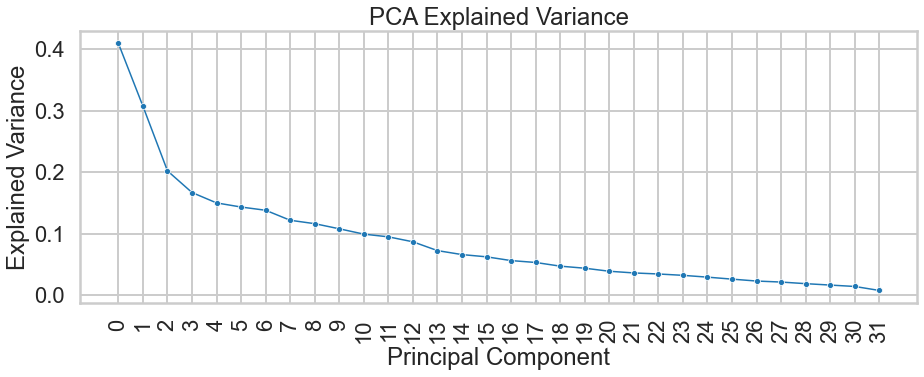

In [229]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
fig, ax = plt.subplots(figsize=(15,5))
y = pca.explained_variance_
x = np.arange(len(y))
_=sns.lineplot(x,y, marker='.', size=20, legend=False)
_=plt.ylabel('Explained Variance')
_=plt.xlabel('Principal Component')
_=plt.title('PCA Explained Variance')
_=plt.xticks(np.arange(len(y)), rotation=90)

__Answer__: The possible optimal number of PC's is 2, since the descent from 2-->3 is suddenly less steep than the descent from 1-->2.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

__Answer__: From our investigations, we found that K=3 clusters was the optimal number of clusters, and PCA = 2 components was the optimal number of components.

For KMeans Clustering, we used the elbow method to find K=3 (I personally was hesitant to go with K=3 since I worried the elbow method was too subjective). We then used the silhouette method to find the optimal K, but we found no K value with a silhouette score greater than 0.25, indicating that no substantial structure was found. At that point, it was better to just go with the elbow sum-of-squares method.

For Principal Component Analysis, we found from plotting the explained variance and looking at the elbow that the optimal number of components was 2. 2 dimensions was best, and this made it easy to visualize the data.

From visualizing the data, we found that our clusters 0 and 2 were well-defined, but cluster 1 was ill-defined.

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


#### 1. Affinity Propagation

In [349]:
# 1. Affinity Propagation
from sklearn.cluster import AffinityPropagation

#Let's try to optimize the damping parameter.
for damping in np.arange(0.5, 1.0, 0.1):
    ap = AffinityPropagation(damping=damping)
    results = ap.fit(X)
    number_clusters = len(np.unique(ap.labels_))
    print("Damping value =", round(damping,2), 'Number of clusters: ', number_clusters)

#The results are either 14 or 11 clusters. A smaller value is probably better for interpretability.

Damping value = 0.5 Number of clusters:  14
Damping value = 0.6 Number of clusters:  14
Damping value = 0.7 Number of clusters:  14
Damping value = 0.8 Number of clusters:  11
Damping value = 0.9 Number of clusters:  11


Affinity Propagation: number of clusters found = 11


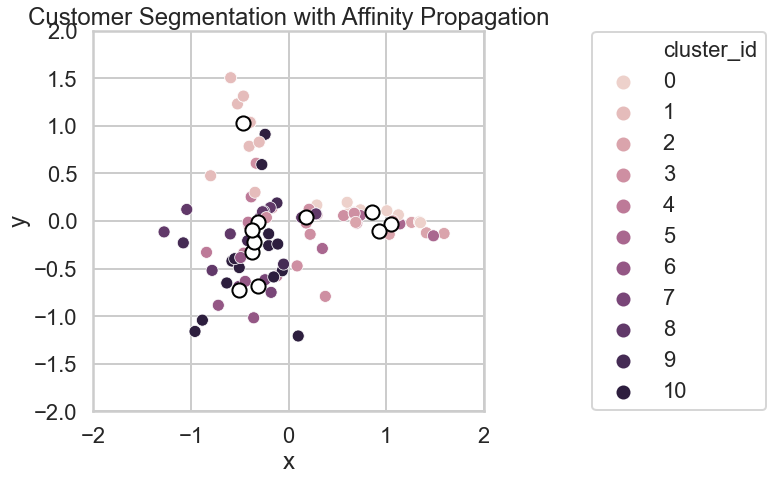

In [350]:
# 1. Affinity Propagation

#PCA with 2 components
from sklearn.decomposition import PCA
X = x_cols
pca = PCA(n_components=2)
results = pca.fit_transform(X)
results_x = []
results_y = []
for i in range(100):
    results_x.append(results[i][0])
    results_y.append(results[i][1])

#Affinity Propagation
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation(damping=0.8)
results = ap.fit(X)
    
df_pca = df_responses[['customer_name']].melt()[['value']] #We use melt() to unpivot our earlier df.
df_pca.columns = ['customer_name'] #rename the column
df_pca['cluster_id'] = ap.labels_
df_pca['x'] = results_x
df_pca['y'] = results_y
df_pca.head()


#Plot a scatterplot of the `x` vs `y` columns
#Color-code points differently based on cluster ID

fig, ax = plt.subplots(figsize=(7,7))
_=plt.title('Customer Segmentation with Affinity Propagation')
_=plt.xlim([-2, 2])
_=plt.ylim([-2, 2])

_=sns.scatterplot(data=df_pca, x='x',y='y', hue='cluster_id', alpha = 1, legend='full')

# Draw circles at cluster centers
center_x=[]
center_y=[]
for i in df_pca.cluster_id.unique():
    x = np.mean(df_pca.x[df_pca.cluster_id==i])
    y = np.mean(df_pca.y[df_pca.cluster_id==i])
    center_x.append(x)
    center_y.append(y)
_=plt.scatter(center_x, center_y, marker='o', c="white", alpha=1, s=200, edgecolor='k')
_=ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

number_clusters = len(np.unique(ap.labels_))
print('Affinity Propagation: number of clusters found =', number_clusters)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[9, 3, 6, 11, 7, 3, 10, 11, 4, 3, 8, 5, 12, 8]


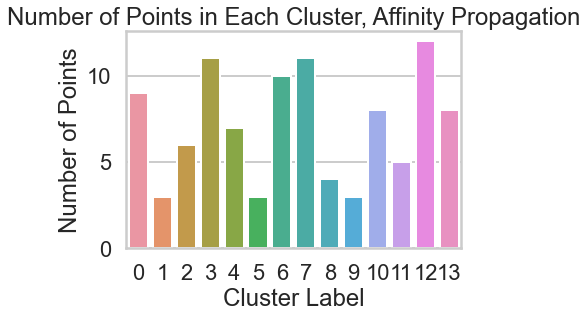

In [256]:
# Affinity Propagation: Number of points in each cluster
array = ap.labels_

x_points = []
y_points = []

for i in range(14):
    x_points.append(i)
    y_points.append(np.count_nonzero(array == i))

_=plt.xlabel('Cluster Label')
_=plt.ylabel('Number of Points')
_=plt.title('Number of Points in Each Cluster, Affinity Propagation')
_=sns.barplot(x_points, y_points)

print(x_points)
print(y_points)

#Note: Some of these clusters have as few as 3 points in the cluster... Perhaps not the best method for our purposes.

#### 2. Spectral Clustering

In [268]:
# 2. Spectral clustering

from sklearn.cluster import spectral_clustering
spectral_clustering(X, n_clusters=3)


ValueError: array must be 2-dimensional and square. shape = (100, 32)

In [ ]:
#PCA with 2 components
from sklearn.decomposition import PCA
X = x_cols
pca = PCA(n_components=2)
results = pca.fit_transform(X)
results_x = []
results_y = []
for i in range(100):
    results_x.append(results[i][0])
    results_y.append(results[i][1])

#Affinity Propagation
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation()
results = ap.fit(X)
    
df_pca = df_responses[['customer_name']].melt()[['value']] #We use melt() to unpivot our earlier df.
df_pca.columns = ['customer_name'] #rename the column
df_pca['cluster_id'] = ap.labels_
df_pca['x'] = results_x
df_pca['y'] = results_y
df_pca.head()


#Plot a scatterplot of the `x` vs `y` columns
#Color-code points differently based on cluster ID

fig, ax = plt.subplots(figsize=(7,7))
_=plt.title('Customer Segmentation with Affinity Propagation')
_=plt.xlim([-2, 2])
_=plt.ylim([-2, 2])

_=sns.scatterplot(data=df_pca, x='x',y='y', hue='cluster_id', alpha = 0.75, legend=False)

# Draw circles at cluster centers
center_x=[]
center_y=[]
for i in df_pca.cluster_id.unique():
    x = np.mean(df_pca.x[df_pca.cluster_id==i])
    y = np.mean(df_pca.y[df_pca.cluster_id==i])
    center_x.append(x)
    center_y.append(y)
_=plt.scatter(center_x, center_y, marker='o', c="white", alpha=1, s=200, edgecolor='k')

number_clusters = len(np.unique(ap.labels_))
print('Affinity Propagation: number of clusters found =', number_clusters)

#### 3. Agglomerative Clustering

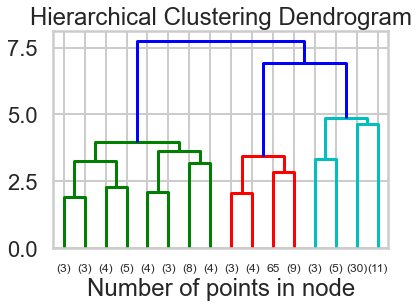

In [298]:
# 3. Agglomerative clustering - dendrogram graph
# We'll plot a dendrogram like the example in this article: 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")
plt.show()

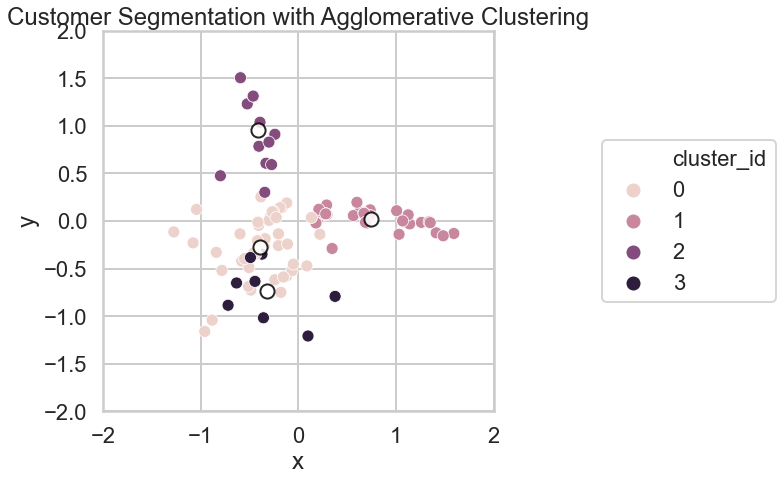

In [351]:
# 3. Agglomerative Clustering

X = x_cols
pca = PCA(n_components=2)
results = pca.fit_transform(X)
results_x = []
results_y = []
for i in range(100):
    results_x.append(results[i][0])
    results_y.append(results[i][1])

ac = AgglomerativeClustering(distance_threshold=None, n_clusters=4) #We can set n_clusters to any number b/w 1-100.
results = ac.fit(X)

df_pca = df_responses[['customer_name']].melt()[['value']] #We use melt() to unpivot our earlier df.
df_pca.columns = ['customer_name'] #rename the column
df_pca['cluster_id'] = ac.labels_
df_pca['x'] = results_x
df_pca['y'] = results_y
df_pca.head()


#Plot a scatterplot of the `x` vs `y` columns
#Color-code points differently based on cluster ID

fig, ax = plt.subplots(figsize=(7,7))
_=plt.title('Customer Segmentation with Agglomerative Clustering')
_=plt.xlim([-2, 2])
_=plt.ylim([-2, 2])

_=sns.scatterplot(data=df_pca, x='x',y='y', hue='cluster_id', alpha = 1, legend='full')

# Draw circles at cluster centers
center_x=[]
center_y=[]
cluster = []
for i in df_pca.cluster_id.unique():
    x = np.mean(df_pca.x[df_pca.cluster_id==i])
    y = np.mean(df_pca.y[df_pca.cluster_id==i])
    center_x.append(x)
    center_y.append(y)
    cluster.append(i)
_=plt.scatter(center_x, center_y, marker='o', c='white', alpha=0.85, s=200, edgecolor='k')
_=ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

#### 4. DBSCAN

In [323]:
# 4. DBSCAN
from sklearn.cluster import DBSCAN

# Note: we want to optimize for eps (default = 0.5)
# When we initialize DBSCAN() without changing the defaults, all of our labels are "-1", 
# meaning we have noisy samples. Avoid too many "-1" values...

for eps in np.arange(0.5,2,0.1):
    dbscan = DBSCAN(eps=eps)
    results = dbscan.fit_predict(X)
    noisy = np.count_nonzero(results == -1)
    cluster0 = np.count_nonzero(results == 0) #note: if everything is labeled "0", then they're all in the same cluster.
    print('eps =', round(eps,2), 'Number of points with -1 label:', noisy, ' and 0 label:', cluster0)

#After trying various ranges, we find that any value above 1.5 results in all values lying in a single cluster (cluster 0)
#or is labeled as -1 (noise). Any value below 1.0 results in all points labeled as -1. 
#The sweet spot is somewhere between 1.1 and 1.4, where 60 points are -1, 7 points are 0, and the remaining 33 points
#have other labels. So we'll go with eps=1.25

eps = 0.5 Number of points with -1 label: 100  and 0 label: 0
eps = 0.6 Number of points with -1 label: 100  and 0 label: 0
eps = 0.7 Number of points with -1 label: 100  and 0 label: 0
eps = 0.8 Number of points with -1 label: 100  and 0 label: 0
eps = 0.9 Number of points with -1 label: 100  and 0 label: 0
eps = 1.0 Number of points with -1 label: 100  and 0 label: 0
eps = 1.1 Number of points with -1 label: 60  and 0 label: 7
eps = 1.2 Number of points with -1 label: 60  and 0 label: 7
eps = 1.3 Number of points with -1 label: 60  and 0 label: 7
eps = 1.4 Number of points with -1 label: 60  and 0 label: 7
eps = 1.5 Number of points with -1 label: 36  and 0 label: 64
eps = 1.6 Number of points with -1 label: 36  and 0 label: 64
eps = 1.7 Number of points with -1 label: 36  and 0 label: 64
eps = 1.8 Number of points with -1 label: 10  and 0 label: 90
eps = 1.9 Number of points with -1 label: 10  and 0 label: 90


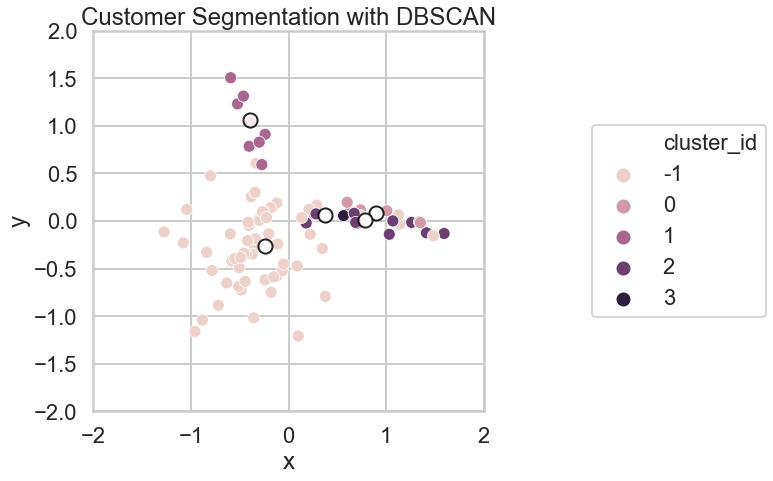

In [341]:
# 4. DBSCAN

X = x_cols
pca = PCA(n_components=2)
results = pca.fit_transform(X)
results_x = []
results_y = []
for i in range(100):
    results_x.append(results[i][0])
    results_y.append(results[i][1])

dbscan = DBSCAN(eps=1.25) #From before, the optimal eps for this dataset is between 1.1 and 1.4
results = dbscan.fit_predict(X)

df_pca = df_responses[['customer_name']].melt()[['value']] #We use melt() to unpivot our earlier df.
df_pca.columns = ['customer_name'] #rename the column
df_pca['cluster_id'] = results
df_pca['x'] = results_x
df_pca['y'] = results_y
df_pca.head()


#Plot a scatterplot of the `x` vs `y` columns
#Color-code points differently based on cluster ID

fig, ax = plt.subplots(figsize=(7,7))
_=plt.title('Customer Segmentation with DBSCAN')
_=plt.xlim([-2, 2])
_=plt.ylim([-2, 2])

_=sns.scatterplot(data=df_pca, x='x',y='y', hue='cluster_id', alpha = 1, legend='full')

# Draw circles at cluster centers
center_x=[]
center_y=[]
cluster = []
for i in df_pca.cluster_id.unique():
    x = np.mean(df_pca.x[df_pca.cluster_id==i])
    y = np.mean(df_pca.y[df_pca.cluster_id==i])
    center_x.append(x)
    center_y.append(y)
    cluster.append(i)
_=plt.scatter(center_x, center_y, marker='o', c='white', alpha=0.85, s=200, edgecolor='k')
_=ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

#### Conclusion
__#How do their results compare? Which performs the best? Tell a story why you think it performs the best.__

1. Affinity propagation
 * Affinity propagation resulted in 11 clusters (14 if we do not change the default damping value), nearly all of which are overlapping. Affinity propagation relies on the similarity between pairs of samples, and converging on the most similar sets of samples. Perhaps in this dataset, too many of the samples are too similar to each other.

2. Spectral clustering
 * (Did not figure out how to get this to work yet...)

3. Agglomerative clustering
 * Agglomerative clustering is an agglomerative hierarchical clustering method; this puts every point in its own cluster and groups them by their similarity/distance. This method worked best. It gave us the flexibility to choose exactly how many clusters we wanted (anwhere between 1 and 100 in this dataset), and let us see which points are most similar to each other. When we choose 3 clusters, we get a result very similar to K-Means, with some edge cases being sorted into different clusters. But when we choose 4 clusters, we can see which points in the ill-defined cluster are more similar to each other and the others. This gives us higher granularity (should we desire it) in the ill-defined cluster, when trying to identify similar traits between customers.

4. DBSCAN
 * Similar to K-Means, there is a ill-defined cluster with points labeled with "-1", indicating that it is a noisy point. The tail at the top of the graph is its own cluster, but the tail on the right has been split into 3 clusters. This should have been grouped as a single cluster, rather than 3 overlapping clusters. This method was not suitable for this dataset because we are assuming there are clusters of similar density, but in reality our density is non-uniform.


Agglomerative Clustering performed best for the aforementioned reasons.